## Preprocessing the Dataset

Create two directories mytrain and myvalid. Each of the two directories further divided into 'cat' and 'dog' and contains images of cats and dogs respectively.

mytrain
- dog

myvalid:
- cat
- dog

In [8]:
import os
import numpy as np
import shutil
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

([<matplotlib.axis.XTick at 0x7f7849a47d68>,
 <a list of 3 Text xticklabel objects>)

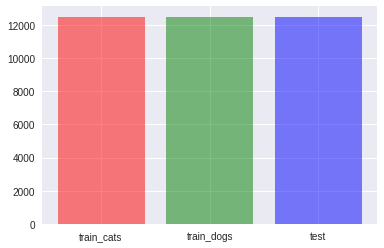

In [43]:
# visulaizing the given dataet
fnames = os.listdir('train')
train_cats = list(filter(lambda x:x[:3] == 'cat', fnames))
train_dogs = list(filter(lambda x:x[:3] == 'dog', fnames))
x = ['train_cats', 'train_dogs', 'test']

y = [len(train_cats), len(train_dogs), len(os.listdir('test'))]
x_pos = np.arange(len(x))

plt.bar(x_pos, y, align='center', alpha=0.5, color= 'rgb')
plt.xticks(x_pos, x)


In [29]:
# splitting the train data into train and validation sets
my_train, my_validation = train_test_split(fnames, test_size=0.1)
print ('# of training samples:',len(my_train),'.....','# of validation samples:', len(my_validation))

# of training samples: 22500 ..... # of validation samples: 2500


([<matplotlib.axis.XTick at 0x7f7849993748>,
 <a list of 4 Text xticklabel objects>)

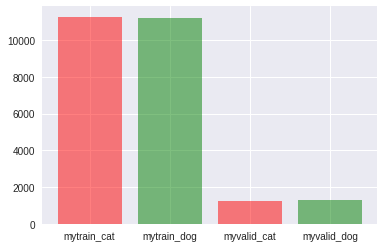

In [45]:
# visualizing the training and validations dataset sizes
mytrain_cat = list(filter(lambda x:x[:3] == 'cat', my_train))
mytrain_dog = list(filter(lambda x:x[:3] == 'dog', my_train))
myvalid_cat = list(filter(lambda x:x[:3] == 'cat', my_validation))
myvalid_dog = list(filter(lambda x:x[:3] == 'dog', my_validation))
x = ['mytrain_cat', 'mytrain_dog', 'myvalid_cat', 'myvalid_dog']
y = [len(mytrain_cat), len(mytrain_dog), len(myvalid_cat), len(myvalid_dog)]

x_pos = np.arange(len(x))

plt.bar(x_pos, y, align='center', alpha=0.5, color= 'rg')
plt.xticks(x_pos, x)


In [9]:
# creating symbolic links for images

def remove_and_create_class(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    os.mkdir(dirname+'/cat')
    os.mkdir(dirname+'/dog')

remove_and_create_class('mytrain')
remove_and_create_class('myvalid')

for filename in mytrain_cat[0:100]:
    os.symlink('../../train/'+filename, 'mytrain/cat/'+filename)

for filename in mytrain_dog[0:100]:
    os.symlink('../../train/'+filename, 'mytrain/dog/'+filename)

for filename in myvalid_cat[0:200]:
    os.symlink('../../train/'+filename, 'myvalid/cat/'+filename)

for filename in myvalid_dog[0:200]:
    os.symlink('../../train/'+filename, 'myvalid/dog/'+filename)

## Creating ResNet-50, training and testing

In [27]:
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import random

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.utils.data_utils import get_file

In [10]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        'mytrain',  
        target_size=image_size, 
        batch_size=10,
        class_mode= 'binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
        'myvalid', 
        target_size=image_size, 4
        batch_size=10,
        class_mode= 'binary', shuffle=False)

Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


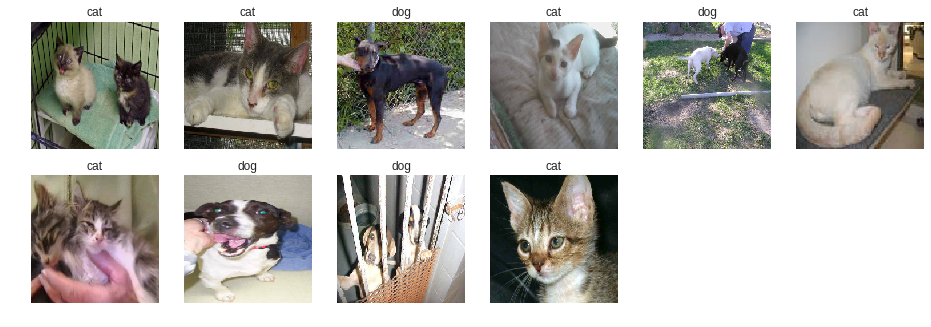

In [13]:
x, y = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

In [14]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x

In [15]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x

In [16]:
img_input = Input(shape=(image_width, image_height, 3))

x = ZeroPadding2D((3, 3))(img_input)
x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, name='bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

base_model = Model(img_input, x)

/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2))`
  after removing the cwd from sys.path.
/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), name="res2a_branch2a", strides=(1, 1))`
  if sys.path[0] == '':
/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="res2a_branch2b", padding="same")`
/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch2c")`
/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 A

/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="res4e_branch2b", padding="same")`
  app.launch_new_instance()
/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1024, (1, 1), name="res4e_branch2c")`
/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res4f_branch2a")`
  # This is added back by InteractiveShellApp.init_path()
/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="res4f_branch2b", padding="same")`
  app.launch_new_instance()
/home/saif/.virtualenvs/mycvenv/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWar

In [11]:
WEIGHTS_PATH_TF = 'https://github.com/fchollet/deep-learning-models/releases/download/\
v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_TF,
                        cache_subdir='models',
                        md5_hash='a268eb855778b3df3c7506639542a6af')
base_model.load_weights(weights_path)

In [17]:
nb_train_samples = 200
nb_validation_samples = 400
batch_size = 10

def save_bottlebeck_features():
    
    base_model.load_weights(weights_path)

    
    bottleneck_features_train = base_model.predict_generator(
        train_generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_train.npy',
            bottleneck_features_train)


    bottleneck_features_validation = base_model.predict_generator(
        validation_generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)
    
save_bottlebeck_features()

In [26]:
epochs = 2000

top_model_weights_path = 'bottleneck_fc_model.h5'

def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    train_labels = np.array(
        [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

    
    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array(
        [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))
   

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))

    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=1e-4)
    model.compile(optimizer=opt,#'adadelta',
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    print(train_data.shape)
    
    model.fit(train_data, train_labels,
              epochs=epochs,
              shuffle = 'false',
              batch_size = batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


    
train_top_model()

(200, 7, 7, 2048)
Train on 200 samples, validate on 400 samples
Epoch 1/2000
200/200 [==============================] - 0s - loss: 0.7449 - acc: 0.5750 - val_loss: 0.6880 - val_acc: 0.5400
Epoch 2/2000
200/200 [==============================] - 0s - loss: 0.7397 - acc: 0.4550 - val_loss: 0.6912 - val_acc: 0.5175
Epoch 3/2000
200/200 [==============================] - 0s - loss: 0.7391 - acc: 0.5100 - val_loss: 0.7475 - val_acc: 0.5000
Epoch 4/2000
200/200 [==============================] - 0s - loss: 0.6893 - acc: 0.5300 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 5/2000
200/200 [==============================] - 0s - loss: 0.6949 - acc: 0.5350 - val_loss: 0.7638 - val_acc: 0.5000
Epoch 6/2000
200/200 [==============================] - 0s - loss: 0.7580 - acc: 0.5200 - val_loss: 0.7506 - val_acc: 0.5000
Epoch 7/2000
200/200 [==============================] - 0s - loss: 0.6963 - acc: 0.5300 - val_loss: 0.7029 - val_acc: 0.5075
Epoch 8/2000
200/200 [==============================] - 0s - 

200/200 [==============================] - 0s - loss: 0.4046 - acc: 0.8900 - val_loss: 0.7567 - val_acc: 0.5225
Epoch 130/2000
200/200 [==============================] - 0s - loss: 0.4416 - acc: 0.7850 - val_loss: 0.9238 - val_acc: 0.5100
Epoch 131/2000
200/200 [==============================] - 0s - loss: 0.4718 - acc: 0.7350 - val_loss: 0.9130 - val_acc: 0.5100
Epoch 132/2000
200/200 [==============================] - 0s - loss: 0.4754 - acc: 0.7250 - val_loss: 0.7397 - val_acc: 0.5325
Epoch 133/2000
200/200 [==============================] - 0s - loss: 0.4758 - acc: 0.7450 - val_loss: 0.7481 - val_acc: 0.5675
Epoch 134/2000
200/200 [==============================] - 0s - loss: 0.5096 - acc: 0.6950 - val_loss: 0.7783 - val_acc: 0.5650
Epoch 135/2000
200/200 [==============================] - 0s - loss: 0.4163 - acc: 0.8250 - val_loss: 0.7356 - val_acc: 0.5425
Epoch 136/2000
200/200 [==============================] - 0s - loss: 0.4003 - acc: 0.8700 - val_loss: 0.7325 - val_acc: 0.5500

200/200 [==============================] - 0s - loss: 0.3127 - acc: 0.8750 - val_loss: 0.8021 - val_acc: 0.5600
Epoch 258/2000
200/200 [==============================] - 0s - loss: 0.2957 - acc: 0.9100 - val_loss: 0.8114 - val_acc: 0.5325
Epoch 259/2000
200/200 [==============================] - 0s - loss: 0.3124 - acc: 0.8800 - val_loss: 0.8192 - val_acc: 0.5425
Epoch 260/2000
200/200 [==============================] - 0s - loss: 0.2880 - acc: 0.9150 - val_loss: 0.8037 - val_acc: 0.5525
Epoch 261/2000
200/200 [==============================] - 0s - loss: 0.2942 - acc: 0.9150 - val_loss: 0.8061 - val_acc: 0.5600
Epoch 262/2000
200/200 [==============================] - 0s - loss: 0.2933 - acc: 0.9250 - val_loss: 0.8551 - val_acc: 0.5575
Epoch 263/2000
200/200 [==============================] - 0s - loss: 0.2951 - acc: 0.9150 - val_loss: 0.8122 - val_acc: 0.5300
Epoch 264/2000
200/200 [==============================] - 0s - loss: 0.2818 - acc: 0.9500 - val_loss: 0.8198 - val_acc: 0.5550

200/200 [==============================] - 0s - loss: 0.2381 - acc: 0.9150 - val_loss: 0.8792 - val_acc: 0.5400
Epoch 386/2000
200/200 [==============================] - 0s - loss: 0.2269 - acc: 0.9450 - val_loss: 0.9068 - val_acc: 0.5200
Epoch 387/2000
200/200 [==============================] - 0s - loss: 0.2435 - acc: 0.9050 - val_loss: 0.8854 - val_acc: 0.5300
Epoch 388/2000
200/200 [==============================] - 0s - loss: 0.2140 - acc: 0.9600 - val_loss: 0.8827 - val_acc: 0.5600
Epoch 389/2000
200/200 [==============================] - 0s - loss: 0.2532 - acc: 0.9150 - val_loss: 0.8977 - val_acc: 0.5450
Epoch 390/2000
200/200 [==============================] - 0s - loss: 0.2272 - acc: 0.9400 - val_loss: 0.8840 - val_acc: 0.5375
Epoch 391/2000
200/200 [==============================] - 0s - loss: 0.2166 - acc: 0.9350 - val_loss: 0.9697 - val_acc: 0.5225
Epoch 392/2000
200/200 [==============================] - 0s - loss: 0.2229 - acc: 0.9550 - val_loss: 0.8855 - val_acc: 0.5575

200/200 [==============================] - 0s - loss: 0.1806 - acc: 0.9550 - val_loss: 1.0054 - val_acc: 0.5225
Epoch 514/2000
200/200 [==============================] - 0s - loss: 0.1718 - acc: 0.9550 - val_loss: 0.9625 - val_acc: 0.5400
Epoch 515/2000
200/200 [==============================] - 0s - loss: 0.1844 - acc: 0.9550 - val_loss: 0.9707 - val_acc: 0.5575
Epoch 516/2000
200/200 [==============================] - 0s - loss: 0.1783 - acc: 0.9450 - val_loss: 1.0168 - val_acc: 0.5225
Epoch 517/2000
200/200 [==============================] - 0s - loss: 0.1749 - acc: 0.9550 - val_loss: 0.9612 - val_acc: 0.5550
Epoch 518/2000
200/200 [==============================] - 0s - loss: 0.1982 - acc: 0.9350 - val_loss: 0.9649 - val_acc: 0.5550
Epoch 519/2000
200/200 [==============================] - 0s - loss: 0.2170 - acc: 0.9000 - val_loss: 1.0878 - val_acc: 0.5600
Epoch 520/2000
200/200 [==============================] - 0s - loss: 0.2352 - acc: 0.9150 - val_loss: 0.9758 - val_acc: 0.5525

200/200 [==============================] - 0s - loss: 0.1662 - acc: 0.9550 - val_loss: 1.0736 - val_acc: 0.5250
Epoch 642/2000
200/200 [==============================] - 0s - loss: 0.1566 - acc: 0.9550 - val_loss: 1.0426 - val_acc: 0.5350
Epoch 643/2000
200/200 [==============================] - 0s - loss: 0.1488 - acc: 0.9500 - val_loss: 1.0537 - val_acc: 0.5425
Epoch 644/2000
200/200 [==============================] - 0s - loss: 0.1500 - acc: 0.9500 - val_loss: 1.0463 - val_acc: 0.5375
Epoch 645/2000
200/200 [==============================] - 0s - loss: 0.1368 - acc: 0.9800 - val_loss: 1.1744 - val_acc: 0.5200
Epoch 646/2000
200/200 [==============================] - 0s - loss: 0.1487 - acc: 0.9650 - val_loss: 1.0605 - val_acc: 0.5350
Epoch 647/2000
200/200 [==============================] - 0s - loss: 0.1424 - acc: 0.9700 - val_loss: 1.0458 - val_acc: 0.5450
Epoch 648/2000
200/200 [==============================] - 0s - loss: 0.1408 - acc: 0.9550 - val_loss: 1.0459 - val_acc: 0.5425

200/200 [==============================] - 0s - loss: 0.1370 - acc: 0.9500 - val_loss: 1.1450 - val_acc: 0.5350
Epoch 770/2000
200/200 [==============================] - 0s - loss: 0.1351 - acc: 0.9550 - val_loss: 1.1661 - val_acc: 0.5275
Epoch 771/2000
200/200 [==============================] - 0s - loss: 0.1165 - acc: 0.9650 - val_loss: 1.1259 - val_acc: 0.5375
Epoch 772/2000
200/200 [==============================] - 0s - loss: 0.1386 - acc: 0.9550 - val_loss: 1.1853 - val_acc: 0.5375
Epoch 773/2000
200/200 [==============================] - 0s - loss: 0.1294 - acc: 0.9550 - val_loss: 1.1502 - val_acc: 0.5375
Epoch 774/2000
200/200 [==============================] - 0s - loss: 0.1189 - acc: 0.9700 - val_loss: 1.1318 - val_acc: 0.5425
Epoch 775/2000
200/200 [==============================] - 0s - loss: 0.1253 - acc: 0.9650 - val_loss: 1.1549 - val_acc: 0.5350
Epoch 776/2000
200/200 [==============================] - 0s - loss: 0.1276 - acc: 0.9650 - val_loss: 1.2818 - val_acc: 0.5225

200/200 [==============================] - 0s - loss: 0.1156 - acc: 0.9550 - val_loss: 1.2162 - val_acc: 0.5425
Epoch 898/2000
200/200 [==============================] - 0s - loss: 0.1072 - acc: 0.9650 - val_loss: 1.2115 - val_acc: 0.5475
Epoch 899/2000
200/200 [==============================] - 0s - loss: 0.1060 - acc: 0.9650 - val_loss: 1.2123 - val_acc: 0.5450
Epoch 900/2000
200/200 [==============================] - 0s - loss: 0.1067 - acc: 0.9800 - val_loss: 1.2117 - val_acc: 0.5300
Epoch 901/2000
200/200 [==============================] - 0s - loss: 0.1009 - acc: 0.9700 - val_loss: 1.2503 - val_acc: 0.5350
Epoch 902/2000
200/200 [==============================] - 0s - loss: 0.1115 - acc: 0.9600 - val_loss: 1.2575 - val_acc: 0.5200
Epoch 903/2000
200/200 [==============================] - 0s - loss: 0.1010 - acc: 0.9750 - val_loss: 1.2318 - val_acc: 0.5325
Epoch 904/2000
200/200 [==============================] - 0s - loss: 0.1075 - acc: 0.9550 - val_loss: 1.2244 - val_acc: 0.5425

200/200 [==============================] - 0s - loss: 0.0989 - acc: 0.9600 - val_loss: 1.3821 - val_acc: 0.5325
Epoch 1026/2000
200/200 [==============================] - 0s - loss: 0.1152 - acc: 0.9600 - val_loss: 1.3814 - val_acc: 0.5325
Epoch 1027/2000
200/200 [==============================] - 0s - loss: 0.0970 - acc: 0.9850 - val_loss: 1.3458 - val_acc: 0.5225
Epoch 1028/2000
200/200 [==============================] - 0s - loss: 0.0936 - acc: 0.9800 - val_loss: 1.3707 - val_acc: 0.5425
Epoch 1029/2000
200/200 [==============================] - 0s - loss: 0.0993 - acc: 0.9650 - val_loss: 1.2960 - val_acc: 0.5450
Epoch 1030/2000
200/200 [==============================] - 0s - loss: 0.0975 - acc: 0.9650 - val_loss: 1.3182 - val_acc: 0.5300
Epoch 1031/2000
200/200 [==============================] - 0s - loss: 0.0932 - acc: 0.9650 - val_loss: 1.3058 - val_acc: 0.5375
Epoch 1032/2000
200/200 [==============================] - 0s - loss: 0.0891 - acc: 0.9850 - val_loss: 1.2930 - val_acc:

200/200 [==============================] - 0s - loss: 0.0922 - acc: 0.9750 - val_loss: 1.3957 - val_acc: 0.5350
Epoch 1154/2000
200/200 [==============================] - 0s - loss: 0.1008 - acc: 0.9750 - val_loss: 1.5434 - val_acc: 0.5150
Epoch 1155/2000
200/200 [==============================] - 0s - loss: 0.1072 - acc: 0.9550 - val_loss: 1.3705 - val_acc: 0.5475
Epoch 1156/2000
200/200 [==============================] - 0s - loss: 0.0946 - acc: 0.9750 - val_loss: 1.3715 - val_acc: 0.5350
Epoch 1157/2000
200/200 [==============================] - 0s - loss: 0.0808 - acc: 0.9750 - val_loss: 1.3780 - val_acc: 0.5250
Epoch 1158/2000
200/200 [==============================] - 0s - loss: 0.0863 - acc: 0.9750 - val_loss: 1.3793 - val_acc: 0.5425
Epoch 1159/2000
200/200 [==============================] - 0s - loss: 0.0861 - acc: 0.9750 - val_loss: 1.4831 - val_acc: 0.5275
Epoch 1160/2000
200/200 [==============================] - 0s - loss: 0.0925 - acc: 0.9500 - val_loss: 1.4018 - val_acc:

200/200 [==============================] - 0s - loss: 0.0691 - acc: 0.9900 - val_loss: 1.4982 - val_acc: 0.5325
Epoch 1281/2000
200/200 [==============================] - 0s - loss: 0.0903 - acc: 0.9700 - val_loss: 1.4479 - val_acc: 0.5200
Epoch 1282/2000
200/200 [==============================] - 0s - loss: 0.0872 - acc: 0.9600 - val_loss: 1.4534 - val_acc: 0.5425
Epoch 1283/2000
200/200 [==============================] - 0s - loss: 0.0693 - acc: 0.9800 - val_loss: 1.5436 - val_acc: 0.5300
Epoch 1284/2000
200/200 [==============================] - 0s - loss: 0.1017 - acc: 0.9650 - val_loss: 1.4473 - val_acc: 0.5325
Epoch 1285/2000
200/200 [==============================] - 0s - loss: 0.0752 - acc: 0.9750 - val_loss: 1.5015 - val_acc: 0.5275
Epoch 1286/2000
200/200 [==============================] - 0s - loss: 0.0755 - acc: 0.9750 - val_loss: 1.4912 - val_acc: 0.5375
Epoch 1287/2000
200/200 [==============================] - 0s - loss: 0.0770 - acc: 0.9600 - val_loss: 1.4538 - val_acc:

200/200 [==============================] - 0s - loss: 0.0685 - acc: 0.9700 - val_loss: 1.5878 - val_acc: 0.5300
Epoch 1409/2000
200/200 [==============================] - 0s - loss: 0.0732 - acc: 0.9600 - val_loss: 1.5420 - val_acc: 0.5325
Epoch 1410/2000
200/200 [==============================] - 0s - loss: 0.0774 - acc: 0.9650 - val_loss: 1.5258 - val_acc: 0.5475
Epoch 1411/2000
200/200 [==============================] - 0s - loss: 0.0733 - acc: 0.9650 - val_loss: 1.5212 - val_acc: 0.5375
Epoch 1412/2000
200/200 [==============================] - 0s - loss: 0.0722 - acc: 0.9700 - val_loss: 1.5328 - val_acc: 0.5200
Epoch 1413/2000
200/200 [==============================] - 0s - loss: 0.0750 - acc: 0.9600 - val_loss: 1.5317 - val_acc: 0.5375
Epoch 1414/2000
200/200 [==============================] - 0s - loss: 0.0869 - acc: 0.9600 - val_loss: 1.5295 - val_acc: 0.5175
Epoch 1415/2000
200/200 [==============================] - 0s - loss: 0.0826 - acc: 0.9650 - val_loss: 1.5218 - val_acc:

200/200 [==============================] - 0s - loss: 0.0793 - acc: 0.9700 - val_loss: 1.5928 - val_acc: 0.5275
Epoch 1537/2000
200/200 [==============================] - 0s - loss: 0.0676 - acc: 0.9650 - val_loss: 1.6148 - val_acc: 0.5350
Epoch 1538/2000
200/200 [==============================] - 0s - loss: 0.0658 - acc: 0.9750 - val_loss: 1.7080 - val_acc: 0.5325
Epoch 1539/2000
200/200 [==============================] - 0s - loss: 0.0745 - acc: 0.9650 - val_loss: 1.6454 - val_acc: 0.5450
Epoch 1540/2000
200/200 [==============================] - 0s - loss: 0.0638 - acc: 0.9700 - val_loss: 1.5952 - val_acc: 0.5300
Epoch 1541/2000
200/200 [==============================] - 0s - loss: 0.0689 - acc: 0.9600 - val_loss: 1.6590 - val_acc: 0.5325
Epoch 1542/2000
200/200 [==============================] - 0s - loss: 0.0717 - acc: 0.9600 - val_loss: 1.6983 - val_acc: 0.5350
Epoch 1543/2000
200/200 [==============================] - 0s - loss: 0.0669 - acc: 0.9750 - val_loss: 1.5987 - val_acc:

200/200 [==============================] - 0s - loss: 0.0660 - acc: 0.9650 - val_loss: 1.8265 - val_acc: 0.5325
Epoch 1665/2000
200/200 [==============================] - 0s - loss: 0.0638 - acc: 0.9800 - val_loss: 1.6822 - val_acc: 0.5200
Epoch 1666/2000
200/200 [==============================] - 0s - loss: 0.0678 - acc: 0.9750 - val_loss: 1.6635 - val_acc: 0.5325
Epoch 1667/2000
200/200 [==============================] - 0s - loss: 0.0640 - acc: 0.9800 - val_loss: 1.7004 - val_acc: 0.5400
Epoch 1668/2000
200/200 [==============================] - 0s - loss: 0.0602 - acc: 0.9800 - val_loss: 1.7090 - val_acc: 0.5400
Epoch 1669/2000
200/200 [==============================] - 0s - loss: 0.0626 - acc: 0.9700 - val_loss: 1.7551 - val_acc: 0.5300
Epoch 1670/2000
200/200 [==============================] - 0s - loss: 0.0706 - acc: 0.9600 - val_loss: 1.7712 - val_acc: 0.5325
Epoch 1671/2000
200/200 [==============================] - 0s - loss: 0.0666 - acc: 0.9750 - val_loss: 1.6672 - val_acc:

200/200 [==============================] - 0s - loss: 0.0558 - acc: 0.9700 - val_loss: 1.7330 - val_acc: 0.5375
Epoch 1793/2000
200/200 [==============================] - 0s - loss: 0.0603 - acc: 0.9650 - val_loss: 1.7355 - val_acc: 0.5375
Epoch 1794/2000
200/200 [==============================] - 0s - loss: 0.0817 - acc: 0.9750 - val_loss: 1.7757 - val_acc: 0.5400
Epoch 1795/2000
200/200 [==============================] - 0s - loss: 0.0580 - acc: 0.9700 - val_loss: 1.7468 - val_acc: 0.5400
Epoch 1796/2000
200/200 [==============================] - 0s - loss: 0.0594 - acc: 0.9750 - val_loss: 1.7392 - val_acc: 0.5200
Epoch 1797/2000
200/200 [==============================] - 0s - loss: 0.0538 - acc: 0.9800 - val_loss: 1.7817 - val_acc: 0.5425
Epoch 1798/2000
200/200 [==============================] - 0s - loss: 0.0585 - acc: 0.9700 - val_loss: 1.7333 - val_acc: 0.5300
Epoch 1799/2000
200/200 [==============================] - 0s - loss: 0.0623 - acc: 0.9600 - val_loss: 1.7469 - val_acc:

200/200 [==============================] - 0s - loss: 0.0614 - acc: 0.9700 - val_loss: 1.7998 - val_acc: 0.5375
Epoch 1921/2000
200/200 [==============================] - 0s - loss: 0.0567 - acc: 0.9750 - val_loss: 1.8572 - val_acc: 0.5375
Epoch 1922/2000
200/200 [==============================] - 0s - loss: 0.0685 - acc: 0.9700 - val_loss: 1.7937 - val_acc: 0.5325
Epoch 1923/2000
200/200 [==============================] - 0s - loss: 0.0672 - acc: 0.9550 - val_loss: 1.8129 - val_acc: 0.5375
Epoch 1924/2000
200/200 [==============================] - 0s - loss: 0.0630 - acc: 0.9800 - val_loss: 1.8201 - val_acc: 0.5225
Epoch 1925/2000
200/200 [==============================] - 0s - loss: 0.0606 - acc: 0.9750 - val_loss: 1.8255 - val_acc: 0.5375
Epoch 1926/2000
200/200 [==============================] - 0s - loss: 0.0582 - acc: 0.9650 - val_loss: 1.8640 - val_acc: 0.5300
Epoch 1927/2000
200/200 [==============================] - 0s - loss: 0.0559 - acc: 0.9700 - val_loss: 1.8003 - val_acc: